In [3]:
from concepts import Context as BaseContext
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [47]:
class Context(BaseContext):
    def __init__(self, objetos, atributos, bools, confianza=0.85, soporte=32/712):
        super().__init__(objetos, atributos, bools)
        self.confianza = confianza
        self.soporte = soporte
        self.base_stem = None
        self.base_luxenburger = None
        self.base_completa = None

    @classmethod
    def desde_dataframe(cls, df, confianza=0.85, soporte=32/712):
        # Eliminar la primera columna del dataframe df que corresponde al id
        df = df.iloc[:, 1:]
        objetos = list(df.index.astype(str))
        atributos = list(df.columns.astype(str))
        bools = [tuple(bool(x) for x in fila) for fila in df.values]
        return cls(objetos, atributos, bools, confianza, soporte)


    def set_confianza(self, confianza):
        """Establece el valor del hiperparámetro confianza."""
        self.confianza = confianza

    def get_confianza(self):
        """Obtiene el valor del hiperparámetro confianza."""
        return self.confianza

    def set_soporte(self, soporte):
        """Establece el valor del hiperparámetro soporte."""
        self.soporte = soporte

    def get_soporte(self):
        """Obtiene el valor del hiperparámetro soporte."""
        return self.soporte
    
    def cerrar(self, conj, impls):
        """Cierra un conjunto de atributos usando la base de implicaciones de entrada."""
        cerrado = set(conj)
        cambios = True
        while cambios:
            cambios = False
            for impl,_,_ in impls:
                if impl[0].issubset(cerrado) and not impl[1].issubset(cerrado):
                    cerrado.update(impl[1])
                    cambios = True
        return cerrado

    def next_closure(self, conjunto, conj_impls):
        """Calcula el siguiente cierre de un conjunto de atributos."""
        rev_set_prop=sorted(self.properties, reverse=True)
        for atributo in rev_set_prop:
            if atributo in conjunto:
                conjunto=conjunto - {atributo}
            else:
                sig_conj_cerrado=self.cerrar(conjunto | {atributo}, conj_impls)
                if all(x >= atributo for x in sig_conj_cerrado - conjunto):
                    return sig_conj_cerrado
        return None
    
    def doble_derivada(self, conjunto):
        """Calcula la doble derivada de un conjunto de atributos."""
        conjunto2 = set(conjunto)
        return set(self.intension(self.extension(conjunto2)))

    def calcular_base_stem(self):
        """Calcula la base Stem de un contexto como lista de tuplas."""
        conj_atrib=set()
        base=[]
        atributos=set(self.properties)
        while conj_atrib!=atributos and conj_atrib!= None:
            conj_atrib_pp=self.doble_derivada(conj_atrib)
            if conj_atrib != conj_atrib_pp:
                implicacion = (conj_atrib, conj_atrib_pp - conj_atrib)
                base.append((implicacion, 1., self.soporte_implicacion(implicacion)))
            conj_atrib = self.next_closure(conj_atrib, base)
        self.base_stem = base
        return base

    def es_cerrado(self, conjunto):
        """Determina si un conjunto de atributos es cerrado en un contexto formal."""
        return conjunto == set(self.intension(self.extension(conjunto)))

    def soporte_atributos(self, conjunto):
        """Calcula el soporte de un conjunto de atributos en un contexto formal."""
        numerador = len(self.extension(conjunto))  # |A'|
        denominador = len(self.objects)  # |O|
        return numerador / denominador

    def soporte_concepto(self, concepto):
        """Calcula el soporte de un concepto en un contexto formal."""
        extension, _ = concepto
        numerador = len(extension)
        denominador = len(self.objects)
        return numerador / denominador

    def sigma_frecuente(self, concepto, sigma):
        """Determina si un concepto es frecuente en un contexto formal."""
        return self.soporte_concepto(concepto) >= sigma

    def es_inmediatamente_inferior(self, Y1, Y2):
        """Determina, por medio de sus conjuntos de atributos, si un concepto es inmediatamente inferior a otro en un contexto formal."""
        if Y1 == Y2:  # Si los conjuntos de atributos son iguales, no son inmediatamente inferiores
            return False
        if not Y1.issubset(Y2):  # Si Y1 no es subconjunto de Y2, no son inmediatamente inferiores
            return False
        if not self.es_cerrado(Y1) or not self.es_cerrado(Y2):  # Si alguno de los conjuntos de atributos no es cerrado, no son inmediatamente inferiores
            return False
        extension1 = self.extension(Y1)
        extension2 = self.extension(Y2)
        vecinos = [(set(extension), set(intension)) for extension, intension in self.neighbors(extension2)]
        conceptoY1 = (set(extension1), Y1)
        if conceptoY1 in vecinos:  # Si el concepto (A', Y1) está en los vecinos de (A'', Y2), entonces Y1 es inmediatamente inferior a Y2
            return True
        else:
            return False

    def soporte_implicacion(self, implicacion):
        """Calcula el soporte de una implicación en un contexto formal."""
        antecedente, consecuente = implicacion
        numerador = len(self.extension(antecedente | consecuente))  # |(Y1 ∪ Y2)'|
        denominador = len(self.objects)  # |O|
        return numerador / denominador

    def confianza_implicacion(self, implicacion):
        """Calcula la confianza de una implicación en un contexto formal."""
        antecedente, consecuente = implicacion
        numerador = len(self.extension(antecedente | consecuente))  # |(Y1 ∪ Y2)'|
        denominador = len(self.extension(antecedente))  # |Y1'|
        if denominador == 0:
            return 1.0
        return numerador / denominador

    def calcular_base_luxenburger(self):
        """Calcula la base de Luxenburger de un contexto formal como lista de tuplas de conjuntos de atributos."""
        base_luxenburger = []
        visitados = set()
        reticulo = self.lattice
        n = len(self.objects)
        def aux_base_luxenburger(concepto_actual):
            """Auxiliar para recorrer cada nodo del reticulo del contexto formal de arriba a abajo."""
            if concepto_actual in visitados: # Si el concepto actual ya fue visitado, no hacer nada
                return
            visitados.add(concepto_actual)
            for vecino in concepto_actual.lower_neighbors: # Recorrer los vecinos inferiores del concepto actual
                intencion_vecino = set(vecino.intent)
                intencion_actual = set(concepto_actual.intent)
                implicacion = (intencion_actual, intencion_vecino - intencion_actual) # Representa la implicacion Act -> Vec\Act
                num_objetos_actual = len(concepto_actual.extent)
                if num_objetos_actual != 0:
                    conf_Implicacion = len(vecino.extent)/num_objetos_actual
                else:
                    conf_Implicacion = 0.
                sop_Implicacion = len(vecino.extent)/n
                if sop_Implicacion >= self.soporte and conf_Implicacion >= self.confianza: # Si la implicacion es frecuente, agregarla a la base de Luxenburger
                    base_luxenburger.append((implicacion, conf_Implicacion, sop_Implicacion))
                elif sop_Implicacion < self.soporte: # Realizar la poda si el soporte es menor al umbral
                    return
                aux_base_luxenburger(vecino)
        aux_base_luxenburger(reticulo[len(reticulo)-1]) # Comenzar desde el concepto superior del reticulo
        self.base_luxenburger = base_luxenburger
        return base_luxenburger
    
    def calcular_base_completa(self):
        """Calcula la base completa como la union de la base Stem y de Luxenburger."""
        if self.base_stem is None:
            raise Exception("Primero debe calcular la base Stem.")
        if self.base_luxenburger is None:
            raise Exception("Primero debe calcular la base de Luxenburger.")

        base_completa = self.base_stem.copy()
        base_completa.extend(self.base_luxenburger)
        self.base_completa = base_completa
        return base_completa
    
    def cerrar_conjunto(self, conjunto):
        """Dado un conjunto de atributos y la base de implicaciones, devuelve el conjunto cerrado."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        cerrado = set(conjunto)
        cambios = True
        while cambios:
            cambios = False
            for implicacion,_,_ in self.base_completa:
                if implicacion[0].issubset(cerrado) and not implicacion[1].issubset(cerrado):
                    cerrado.update(implicacion[1])
                    cambios = True
        return cerrado
    
    def entrenar(self):
        """Calcula todas las bases de un contexto formal."""
        self.calcular_base_stem()
        self.calcular_base_luxenburger()
        self.calcular_base_completa()
    
    def predecir(self, datos):
        """Predice las etiquetas de un dataframe de Xs y vacios aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        etiquetas = []
        datos.drop(columns=["Survived"], inplace=True, errors='ignore')
        for i in range(len(datos)):
            instancia = datos.iloc[i]
            conjunto = set(datos.columns[1:][instancia.iloc[1:] == 1])
            cerrado = self.cerrar_conjunto(conjunto)
            if "Survived" in cerrado:
                etiquetas.append(1)
            else:
                etiquetas.append(0)
        return pd.Series(etiquetas, index=datos.index, name="Survived")
    
    def precision(self, datos, etiquetas):
        """Calcula la precisión de un dataframe de Xs y vacios con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base de Luxenburger.")
        predicciones = self.predecir(datos)
        coincidencias = predicciones == etiquetas
        return float(round(coincidencias.mean(), 3))
    
    def falsos_positivos(self, datos, etiquetas):
        """Calcula la cantidad de falsos positivos de un dataframe de datos con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        predicciones = self.predecir(datos)
        falsos_positivos = ((predicciones == 1) & (etiquetas == 0)).sum()
        return falsos_positivos
    
    def falsos_negativos(self, datos, etiquetas):
        """Calcula la cantidad de falsos negativos de un dataframe de datos con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        predicciones = self.predecir(datos)
        falsos_negativos = ((predicciones == 0) & (etiquetas == 1)).sum()
        return falsos_negativos
    
    def calcula_resultados(self, datos, etiquetas):
        """Calcula la precisión, falsos positivos y falsos negativos de un dataframe de datos con sus etiquetas aplicando el metodo XAI de la base completa."""
        if self.base_completa is None:
            raise Exception("Primero debe calcular la base completa.")
        predicciones = self.predecir(datos)
        coincidencias = predicciones == etiquetas
        falsos_positivos = ((predicciones == 1) & (etiquetas == 0)).sum()
        falsos_negativos = ((predicciones == 0) & (etiquetas == 1)).sum()
        return float(round(coincidencias.mean(), 3)), int(falsos_positivos), int(falsos_negativos)

In [ ]:
def analizar_hiperparametros(df):
    '''Esta función calcula las gráficas del capítulo 5 sección 4'''
    # Renombramos las columnas para facilitar la comprensión
    df.columns = ["PSnF", "PS", "PL", "PC", "FP", "FN", "atributos", "Total", "confianza", "soporte", "SA", "SF"]

    plt.rcParams.update({
    'font.size': 20,        # Tamaño general
    'axes.titlesize': 20,   # Título del gráfico
    'axes.labelsize': 20,   # Etiquetas de ejes
    'xtick.labelsize': 20,  # Tamaño de los números del eje X
    'ytick.labelsize': 20,  # Tamaño de los números del eje Y
    'legend.fontsize': 16,        # Tamaño del texto de la leyenda
    'legend.title_fontsize': 20, 
    })
    # 1. Gráfico de líneas de los ratios según el soporte
    plt.figure(figsize=(12, 6))
    for col in ["PSnF", "PS", "PL", "PC"]:
        sns.lineplot(data=df, x="soporte", y=col, label=col)
    plt.title("Ratios de Acierto Según el Soporte Mínimo", weight='bold')
    plt.xlabel("Soporte Mínimo")
    plt.ylabel("Ratio de Acierto")
    plt.legend(title="Bases")
    plt.tight_layout()
    plt.show()
    # Descripción: Este gráfico muestra cómo varían los ratios de acierto de diferentes bases en función del soporte mínimo.

    # 2. Gráfico de líneas de los ratios según la confianza
    plt.figure(figsize=(12, 6))
    for col in ["PSnF", "PS", "PL", "PC"]:
        sns.lineplot(data=df, x="confianza", y=col, label=col)
    plt.title("Ratios de Acierto Según la Confianza Mínima", weight='bold')
    plt.xlabel("Confianza Mínima")
    plt.ylabel("Ratio de Acierto")
    plt.legend(title="Bases")
    plt.tight_layout()
    plt.show()
    # Descripción: Este gráfico muestra cómo los ratios de acierto cambian en función de la confianza mínima establecida en las implicaciones.


    # 1 y 2. Gráficos de líneas de los ratios según soporte y confianza
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    for col in ["PSnF", "PS", "PL", "PC"]:
        sns.lineplot(data=df, x="soporte", y=col, ax=axs[0], label=col)
        sns.lineplot(data=df, x="confianza", y=col, ax=axs[1], label=col)

    axs[0].set_title("Ratios de Acierto Según el Soporte Mínimo", weight='bold')
    axs[0].set_xlabel("Soporte Mínimo")
    axs[0].set_ylabel("Ratio de Acierto")
    axs[0].legend(title="Bases")

    axs[1].set_title("Ratios de Acierto Según la Confianza Mínima", weight='bold')
    axs[1].set_xlabel("Confianza Mínima")
    axs[1].set_ylabel("Ratio de Acierto")
    axs[1].legend(title="Bases")

    plt.tight_layout()
    plt.show()
    # 3. Mapa de calor de correlaciones

    # Descripción: El mapa de calor muestra las correlaciones entre las distintas variables. Valores cercanos a 1 indican una fuerte correlación positiva, mientras que valores cercanos a -1 indican una correlación negativa.

    # Definimos los hiperparámetros
    cols_interes = ["confianza", "soporte", "SA", "SF"]

    # Calculamos la matriz completa de correlaciones
    corr = df.corr()

    # Eliminamos los propios hiperparámetros del eje Y, dejando solo las correlaciones de otras variables con ellos
    corr_interes = corr.drop(index=cols_interes)[cols_interes]

    # Mapa de calor mostrando solo cómo cada variable (excepto los hiperparámetros) se relaciona con los hiperparámetros
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_interes, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            annot_kws={'size': 12}, cbar_kws={'shrink': 0.8})
    plt.title("Mapa de Correlaciones de los Hiperparámetros", weight='bold')
    plt.xlabel("Hiperparámetros")
    plt.ylabel("Variables correlacionadas")
    plt.tight_layout()
    plt.show()
    # Descripción: Este mapa de calor muestra las correlaciones entre los hiperparámetros y el resto de variables. Los valores cercanos a 1 indican una fuerte correlación positiva, mientras que valores cercanos a -1 indican una correlación negativa.
    
    
    # 4. Falsos Positivos (FP) y Falsos Negativos (FN) vs Soporte y Confianza
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.lineplot(data=df, x="soporte", y="FP", ax=axs[0], label="Falsos Positivos", color='green')
    sns.lineplot(data=df, x="soporte", y="FN", ax=axs[0], label="Falsos Negativos", color='red')
    sns.lineplot(data=df, x="soporte", y=df["FP"] + df["FN"], ax=axs[0], label="Suma FP + FN", color='black')
    axs[0].set_title("Falsos Positivos y Negativos Según el Soporte", weight='bold')
    axs[0].set_xlabel("Soporte Mínimo")
    axs[0].set_ylabel("Cantidad de Falsos")
    axs[0].legend(title="Tipo de Falsos")
    
    sns.lineplot(data=df, x="confianza", y="FP", ax=axs[1], label="Falsos Positivos", color='green')
    sns.lineplot(data=df, x="confianza", y="FN", ax=axs[1], label="Falsos Negativos", color='red')
    sns.lineplot(data=df, x="confianza", y=df["FP"] + df["FN"], ax=axs[1], label="Suma FP + FN", color='black')
    axs[1].set_title("Falsos Positivos y Negativos Según la Confianza", weight='bold')
    axs[1].set_xlabel("Confianza Mínima")
    axs[1].set_ylabel("Cantidad de Falsos")
    axs[1].legend(title="Tipo de Falsos")

    plt.tight_layout()
    plt.show()
    # Descripción: Estos gráficos muestran cómo los falsos positivos (FP) y falsos negativos (FN) cambian en función del soporte mínimo y la confianza mínima.

    # 5. Relación entre el número de implicaciones y el ratio de acierto
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="Total", y="PC", hue="confianza", size="soporte", palette="viridis")
    plt.title("Relación Total de Implicaciones y el Ratio de Acierto de la Completa", weight='bold')
    plt.xlabel("Número Total de Implicaciones")
    plt.ylabel("Ratio de Acierto (PC)")
    plt.tight_layout()
    plt.show()
    # Descripción: Este gráfico de dispersión muestra la relación entre el número total de implicaciones (Total) y el ratio de acierto de la base completa (PC), destacando la influencia de la confianza y el soporte.

    # 6. Relación entre Falsos Positivos (FP), Falsos Negativos (FN) y el Ratio de Acierto
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="FP", y="PC", hue="FN", palette="magma", size="Total")
    plt.title("Impacto de FP y FN sobre el Ratio de Acierto de la Completa", weight='bold')
    plt.xlabel("Falsos Positivos")
    plt.ylabel("Ratio de Acierto (PC)")
    plt.tight_layout()
    plt.show()
    # Descripción: Este gráfico de dispersión muestra cómo los falsos positivos (FP) y falsos negativos (FN) afectan al ratio de acierto de la completa (PC).

    # 7. Impacto del número de rangos de edad (SA) sobre el ratio de acierto (PC)
    plt.figure(figsize=(12, 6))
    for col in ["PSnF", "PS", "PL", "PC"]:
        sns.lineplot(data=df, x="SA", y=col, label=col)
    plt.title("Impacto del Número de Rangos de Edad (SA) en el Ratio de Acierto (PC)", weight='bold')
    plt.xlabel("Rangos de Edad")
    plt.ylabel("Ratio de Acierto")
    plt.legend(title="Bases")
    plt.tight_layout()
    plt.show()
    # Descripción: Este gráfico muestra cómo los diferentes rangos de edad (SA) afectan el ratio de acierto de la completa (PC) en cada base de datos.

    # 8. Impacto del número de rangos de tarifa (SF) sobre el ratio de acierto (PC)
    plt.figure(figsize=(12, 6))
    for col in ["PSnF", "PS", "PL", "PC"]:
        sns.lineplot(data=df, x="SF", y=col, label=col)
    plt.title("Impacto del Número de Rangos de Tarifa (SF) en el Ratio de Acierto (PC)", weight='bold')
    plt.xlabel("Rangos de Tarifa")
    plt.ylabel("Ratio de Acierto")
    plt.legend(title="Bases")
    plt.tight_layout()
    plt.show()
    # Descripción: Este gráfico muestra cómo los diferentes rangos de tarifa (SF) impactan el ratio de acierto de la completa (PC) en cada base de datos.

    # 7 y 8. Impacto de SA y SF en el Ratio de Acierto (PC)
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    for col in ["PSnF", "PS", "PL", "PC"]:
        sns.lineplot(data=df, x="SA", y=col, ax=axs[0], label=col)
        sns.lineplot(data=df, x="SF", y=col, ax=axs[1], label=col)

    axs[0].set_title("Impacto del Nº de Rangos de Edad (SA)", weight='bold')
    axs[0].set_xlabel("Rangos de Edad")
    axs[0].set_ylabel("Ratio de Acierto")
    axs[0].legend(title="Bases")

    axs[1].set_title("Impacto del Nº de Rangos de Tarifa (SF)", weight='bold')
    axs[1].set_xlabel("Rangos de Tarifa")
    axs[1].set_ylabel("Ratio de Acierto")
    axs[1].legend(title="Bases")

    plt.tight_layout()
    plt.show()

    # Descripción: 

    return df["SA"].unique().tolist(), df["SF"].unique().tolist()


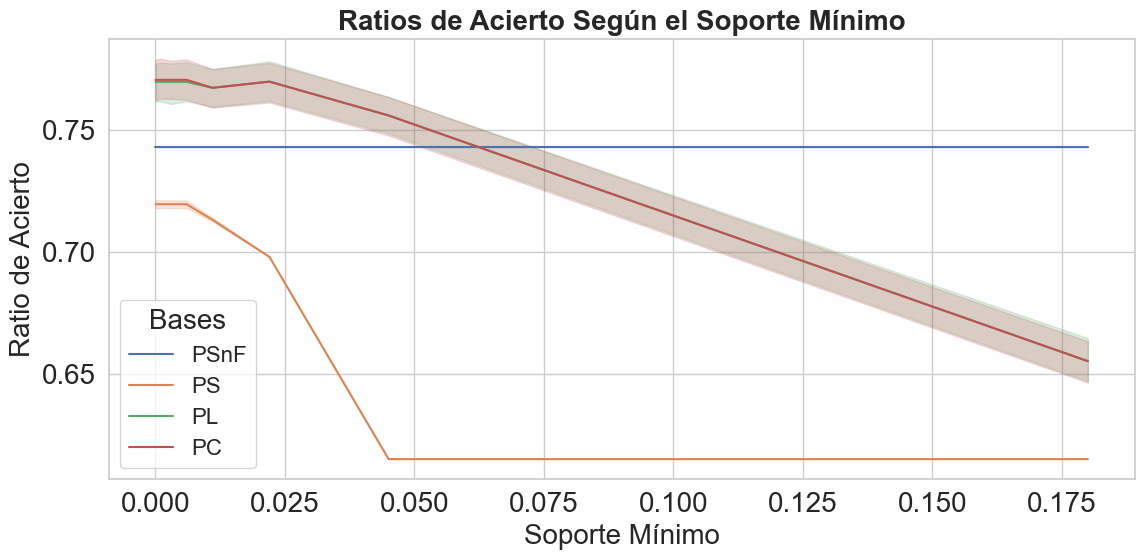

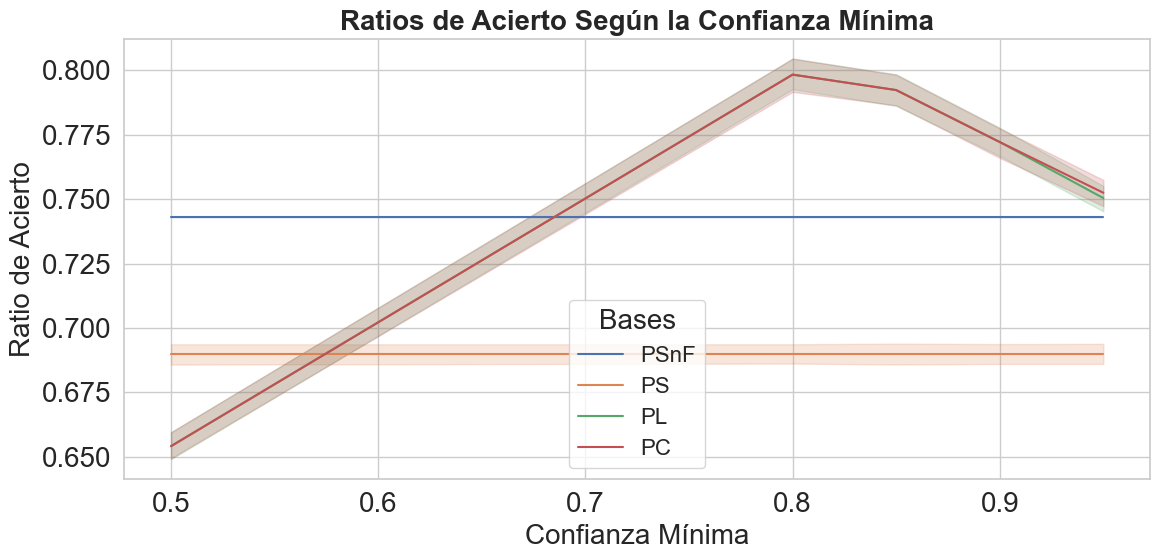

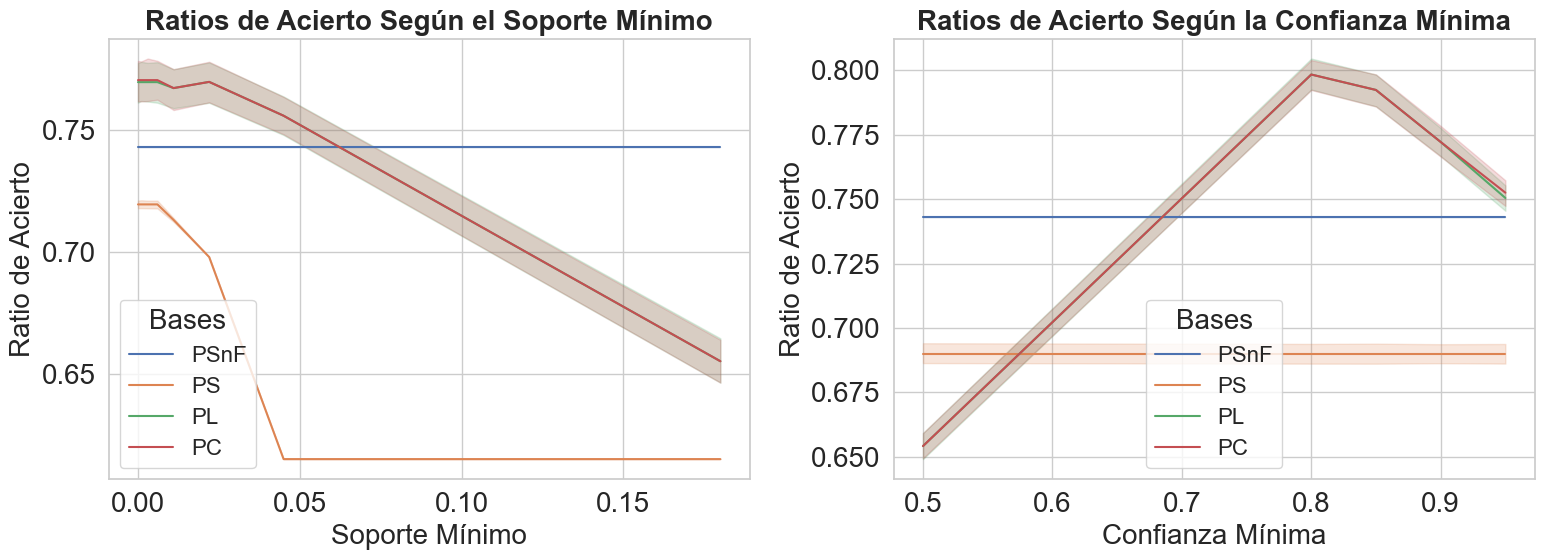

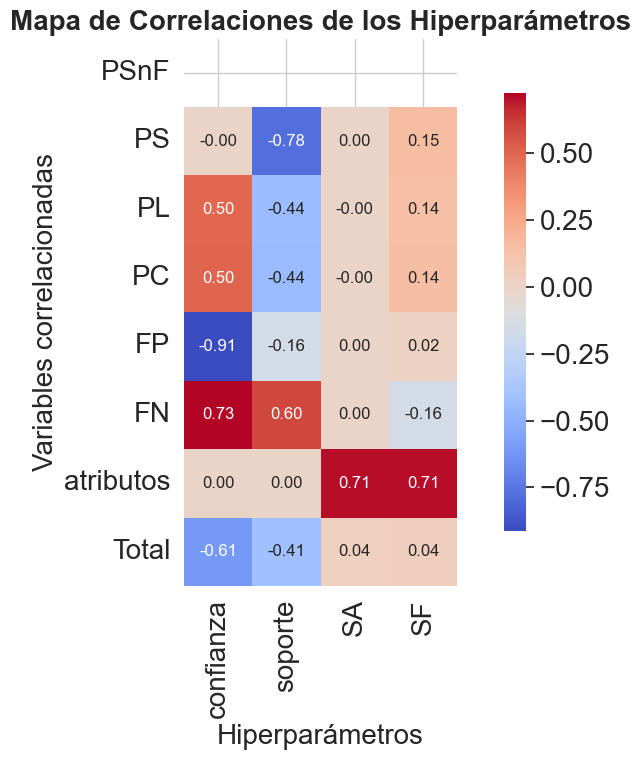

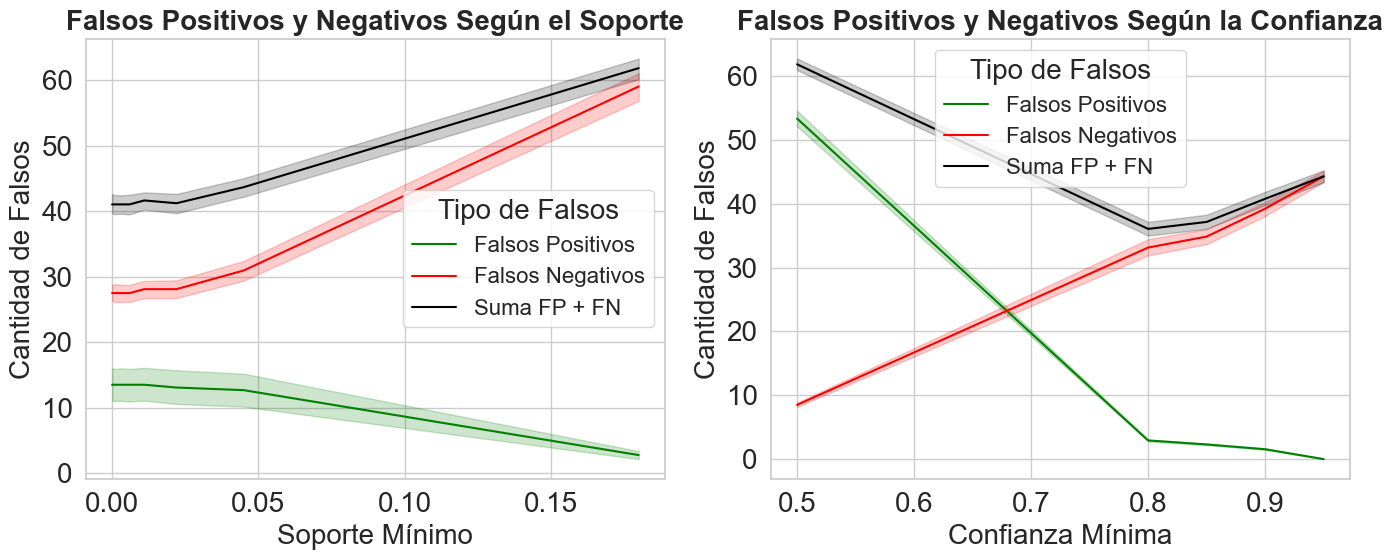

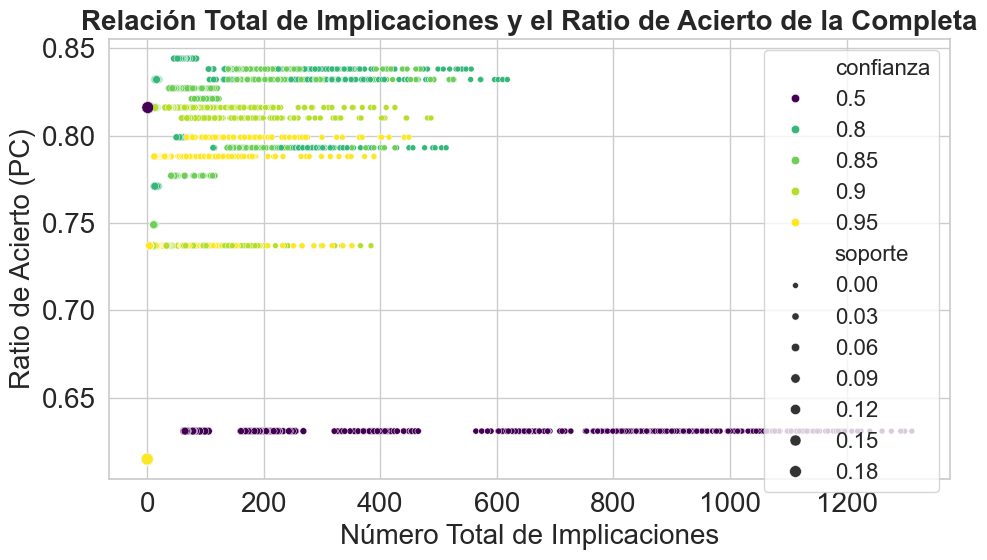

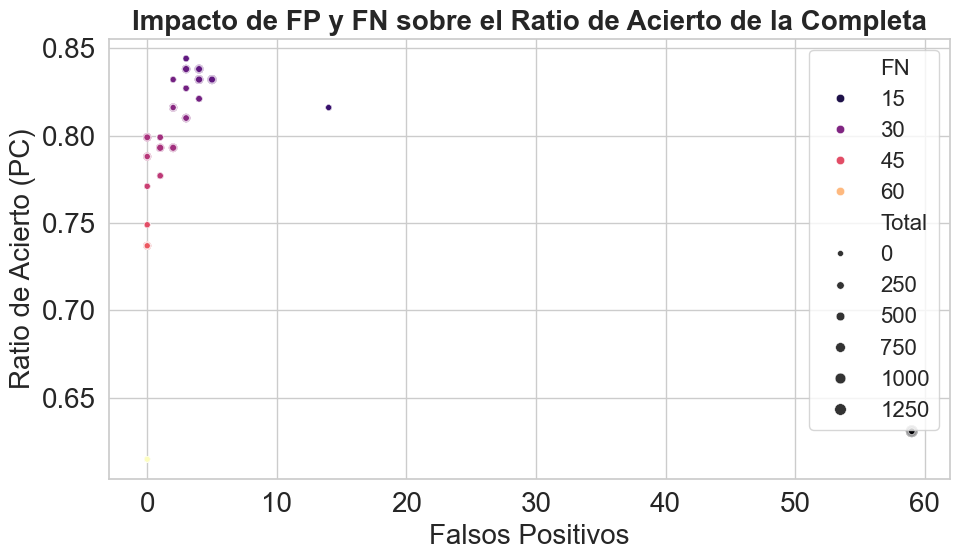

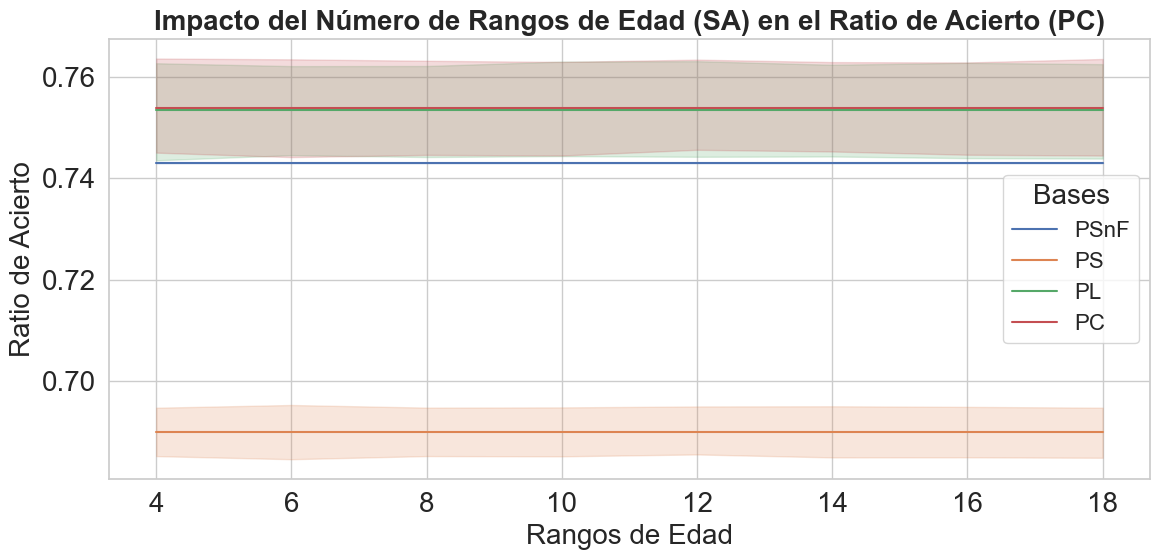

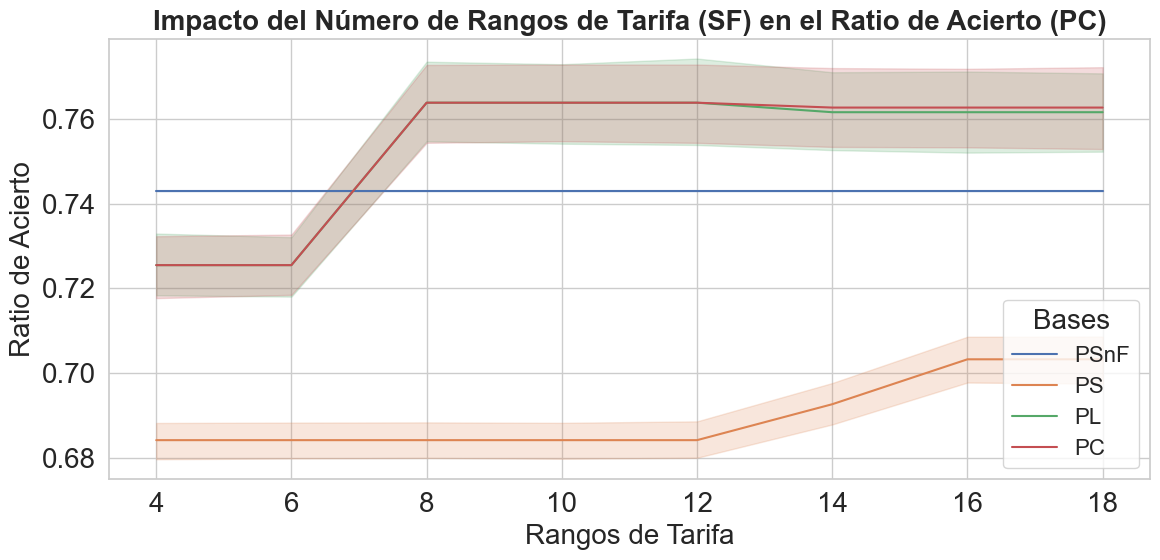

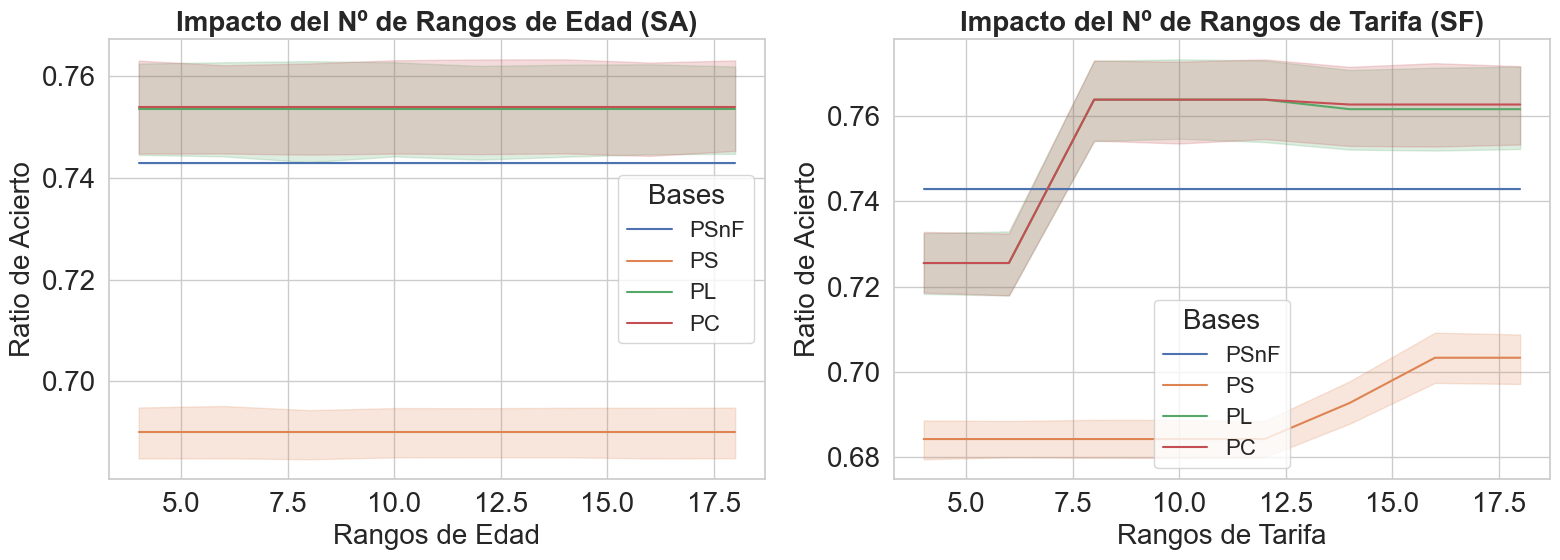

([4, 6, 8, 10, 12, 14, 16, 18], [4, 6, 8, 10, 12, 14, 16, 18])

In [9]:
df = pd.read_csv("ajuste_hiperparametros2.csv")
analizar_hiperparametros(df)

In [49]:
data = pd.read_csv("train.csv")

# Reemplazar valores nulos con el valor más frecuente
data.loc[:, 'Sex'] = data['Sex'].fillna(data['Sex'].mode()[0])
data.loc[:, 'Age'] = data['Age'].fillna(data['Age'].median())
data.loc[:, 'Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data.loc[:, 'Pclass'] = data['Pclass'].fillna(data['Pclass'].mode()[0])
data.loc[:, 'Fare'] = data['Fare'].fillna(data['Fare'].mean())
data.loc[:, 'SibSp'] = data['SibSp'].fillna(data['SibSp'].mode()[0])
data.loc[:, 'Parch'] = data['Parch'].fillna(data['Parch'].mode()[0])


# Definir intervalos y etiquetas de SibSp
sibsp_bins = [0, 1, 3, 5, 7, float('inf')]
sibsp_labels = ["0-1", "1-3", "3-5", "5-7", "7+"]

# Crear una nueva columna con categorías de SibSp
data["SibSpGroup"] = pd.cut(data["SibSp"], bins=sibsp_bins, labels=sibsp_labels, right=False)

# Definir intervalos y etiquetas de Parch
parch_bins = [0, 1, 3, 5, float('inf')]
parch_labels = ["0-1", "1-3", "3-5", "5+"]

# Crear una nueva columna con categorías de Parch
data["ParchGroup"] = pd.cut(data["Parch"], bins=parch_bins, labels=parch_labels, right=False)

# Convertir a codificación one-hot (columnas 1/0)
data = pd.get_dummies(data, columns=["Embarked", "Pclass", "SibSpGroup", "ParchGroup"], dtype=int, drop_first=False)

# Convertir columnas a 1/0
data['Male'] = data['Sex'].map({'male': 1, 'female': 0})
data['Female'] = data['Sex'].map({'male': 0, 'female': 1})

# Añadir una columna que sea la contraria de la columna 'Survived'
#data['NotSurvived'] = data['Survived'].map({0: 1, 1: 0})

# Eliminar las columnas inútiles
data.drop(['Sex', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1, inplace=True)


# Mostrar los nombres de las columnas
#print("Nombres de las columnas:", data.columns)

# Guardar el resultado final en un archivo CSV
data.to_csv("trainDummy.csv", index=False)

In [50]:
def ajusteHiperparametros(datos, rangos_age, rangos_fare, confianzas, soportes):
    """Ajusta los hiperparámetros de confianza y soporte para maximizar la precisión."""
    resultados = []

    def dividir_intervalo(n):
        """Divide un intervalo en partes de tamaño creciente."""
        return [(i / n) ** 2 for i in range(n + 1)]


    datos_entrenamiento, datos_prueba = train_test_split(datos, test_size=0.2, random_state=42, stratify=data['Survived'])
    etiquetas = datos_prueba['Survived']
    datos_prueba.drop(['Survived'], axis=1, inplace=True)

    for separacion_age in rangos_age:
        for separacion_fare in rangos_fare:
            # Crear una copia de los datos para evitar modificar el original
            age_bins = [i/separacion_age*81 for i in range(separacion_age+1)]
            age_labels = [f"{int(age_bins[i])}-{int(age_bins[i+1])}" for i in range(len(age_bins)-1)]
                    
            fare_bins = [i/separacion_fare*513 for i in range(separacion_fare+1)]
            fare_labels = [f"{int(fare_bins[i])}-{int(fare_bins[i+1])}" for i in range(len(fare_bins)-1)]

            datos_copy = datos_entrenamiento.copy()
            datos_copy["AgeGroup"] = pd.cut(datos_copy["Age"], bins=age_bins, labels=age_labels, right=False)
            datos_copy["FareGroup"] = pd.cut(datos_copy["Fare"], bins=fare_bins, labels=fare_labels, right=False)

            datos_copy = pd.get_dummies(datos_copy, columns=["AgeGroup", "FareGroup"], dtype=int, drop_first=False)
            datos_copy.drop(["Age", "Fare"], axis=1, inplace=True)
            
            datos_copy.to_csv("datos_ajuste_hiperparametros.csv", index=False)
            contexto = Context.desde_dataframe(datos_copy)
            base_stem = contexto.calcular_base_stem()

            for confianza in confianzas:
                for soporte in soportes:
                    # Entrenar el contexto con los nuevos datos
                    contexto.set_confianza(confianza)
                    contexto.set_soporte(soporte)
                    base_luxen = contexto.calcular_base_luxenburger()
                    contexto.calcular_base_completa()
                    contexto.base_completa = [i for i in contexto.base_completa if i[2] >= soporte and 'Survived' not in i[0][0] and 'Survived' in i[0][1]]

                    # Calcular la precisión
                    precision, falsos_positivos, falsos_negativos = contexto.calcula_resultados(datos_prueba, etiquetas)

                    # Guardar los resultados
                    dicc = {
                        "precision": precision,
                        "FP": falsos_positivos,
                        "FN": falsos_negativos,
                        "atributos": len(contexto.properties),
                        "Total": len(contexto.base_completa),
                        "confianza": confianza,
                        "soporte": round(soporte, 3),
                        "SA": separacion_age,
                        "SF": separacion_fare
                    }
                    resultados.append(dicc)
    df = pd.DataFrame(resultados)
    df.to_csv("ajuste_hiperparametros2.csv", index=False)
    return resultados

In [ ]:
def ajusteHiperparametros2(datos, rangos_age, rangos_fare, confianzas, soportes):
    """Ajusta los hiperparámetros de confianza y soporte para maximizar la precisión."""
    resultados = []


    datos_entrenamiento, datos_prueba = train_test_split(datos, test_size=0.2, random_state=40, stratify=data['Survived'])
    etiquetas = datos_prueba['Survived']
    datos_prueba.drop(['Survived'], axis=1, inplace=True)

    for separacion_age in rangos_age:
        for separacion_fare in rangos_fare:
            # Crear una copia de los datos para evitar modificar el original
            age_bins = [i/separacion_age*81 for i in range(separacion_age+1)]
            age_labels = [f"{int(age_bins[i])}-{int(age_bins[i+1])}" for i in range(len(age_bins)-1)]
                    
            fare_bins = [i/separacion_fare*513 for i in range(separacion_fare+1)]
            fare_labels = [f"{int(fare_bins[i])}-{int(fare_bins[i+1])}" for i in range(len(fare_bins)-1)]

            datos_copy = datos_entrenamiento.copy()
            datos_copy["AgeGroup"] = pd.cut(datos_copy["Age"], bins=age_bins, labels=age_labels, right=False)
            datos_copy["FareGroup"] = pd.cut(datos_copy["Fare"], bins=fare_bins, labels=fare_labels, right=False)

            datos_copy = pd.get_dummies(datos_copy, columns=["AgeGroup", "FareGroup"], dtype=int, drop_first=False)
            datos_copy.drop(["Age", "Fare"], axis=1, inplace=True)
            
            datos_copy.to_csv("datos_ajuste_hiperparametros.csv", index=False)
            contexto = Context.desde_dataframe(datos_copy)

            base_stem = contexto.calcular_base_stem()
            contexto.base_luxenburger = []
            contexto.calcular_base_completa()
            precisionStemSinFiltro = contexto.precision(datos_prueba, etiquetas)

            for soporte in soportes:
                contexto.base_stem = base_stem
                contexto.base_luxenburger = []
                contexto.calcular_base_completa()
                contexto.base_completa = [i for i in contexto.base_completa if i[2] >= soporte and 'Survived' not in i[0][0] and 'Survived' in i[0][1]]
                precisionStem = contexto.precision(datos_prueba, etiquetas)
                
                for confianza in confianzas:
                    # Entrenar el contexto con los nuevos datos
                    
                    contexto.set_confianza(confianza)
                    contexto.set_soporte(soporte)
                    base_luxen = contexto.calcular_base_luxenburger()
                    contexto.base_stem = []
                    contexto.calcular_base_completa()
                    contexto.base_completa = [i for i in contexto.base_completa if i[2] >= soporte and 'Survived' not in i[0][0] and 'Survived' in i[0][1]]
                    
                    precisionLuxen,_,_= contexto.calcula_resultados(datos_prueba, etiquetas)

                    contexto.base_stem = base_stem
                    contexto.base_luxenburger = base_luxen
                    contexto.calcular_base_completa()
                    contexto.base_completa = [i for i in contexto.base_completa if i[2] >= soporte and 'Survived' not in i[0][0] and 'Survived' in i[0][1]]

                    precisionCompleta, falsos_positivos, falsos_negativos = contexto.calcula_resultados(datos_prueba, etiquetas)

                    # Guardar los resultados
                    dicc = {
                        "PSnF": precisionStemSinFiltro,
                        "PS": precisionStem,
                        "PL": precisionLuxen,
                        "PC": precisionCompleta,
                        "FP": falsos_positivos,
                        "FN": falsos_negativos,
                        "atributos": len(contexto.properties),
                        "Total": len(contexto.base_completa),
                        "confianza": confianza,
                        "soporte": round(soporte, 3),
                        "SA": separacion_age,
                        "SF": separacion_fare
                    }
                    resultados.append(dicc)
            df = pd.DataFrame(resultados)
            df.to_csv("ajuste_hiperparametros3.csv", index=False)
    df = pd.DataFrame(resultados)
    df.to_csv("ajuste_hiperparametros3.csv", index=False)
    return resultados

In [56]:
res = ajusteHiperparametros2(data, [8], [8], [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], [0.0, 1/712, 2/712, 3/712 ,4/712, 8/712, 32/712, 128/712])

In [57]:
lista = res.copy()
print(max(lista, key=lambda x: x["PC"]))

{'PSnF': 0.743, 'PS': 0.615, 'PL': 0.849, 'PC': 0.849, 'FP': 8, 'FN': 19, 'atributos': 34, 'Total': 28, 'confianza': 0.75, 'soporte': 0.045, 'SA': 8, 'SF': 8}


In [ ]:
res2 = ajusteHiperparametros2(data, [4, 6, 8, 10, 12, 14, 16, 18], [4, 6, 8, 10, 12, 14, 16, 18], [0.5, 0.8, 0.85, 0.9, 0.95], [0.0, 1/712, 2/712, 4/712, 8/712, 16/712, 32/712, 128/712])

In [7]:
lista2 = res2.copy()

for i in sorted(lista2, key=lambda x: x["PC"], reverse=True):
    print(i)

{'PSnF': 0.743, 'PS': 0.698, 'PL': 0.844, 'PC': 0.844, 'FP': 3, 'FN': 25, 'atributos': 30, 'Total': 82, 'confianza': 0.8, 'soporte': 0.022, 'SA': 4, 'SF': 8}
{'PSnF': 0.743, 'PS': 0.698, 'PL': 0.844, 'PC': 0.844, 'FP': 3, 'FN': 25, 'atributos': 32, 'Total': 78, 'confianza': 0.8, 'soporte': 0.022, 'SA': 4, 'SF': 10}
{'PSnF': 0.743, 'PS': 0.698, 'PL': 0.844, 'PC': 0.844, 'FP': 3, 'FN': 25, 'atributos': 34, 'Total': 75, 'confianza': 0.8, 'soporte': 0.022, 'SA': 4, 'SF': 12}
{'PSnF': 0.743, 'PS': 0.698, 'PL': 0.844, 'PC': 0.844, 'FP': 3, 'FN': 25, 'atributos': 36, 'Total': 68, 'confianza': 0.8, 'soporte': 0.022, 'SA': 4, 'SF': 14}
{'PSnF': 0.743, 'PS': 0.698, 'PL': 0.844, 'PC': 0.844, 'FP': 3, 'FN': 25, 'atributos': 38, 'Total': 84, 'confianza': 0.8, 'soporte': 0.022, 'SA': 4, 'SF': 16}
{'PSnF': 0.743, 'PS': 0.698, 'PL': 0.844, 'PC': 0.844, 'FP': 3, 'FN': 25, 'atributos': 40, 'Total': 78, 'confianza': 0.8, 'soporte': 0.022, 'SA': 4, 'SF': 18}
{'PSnF': 0.743, 'PS': 0.698, 'PL': 0.844, 'PC':

In [18]:
def ajusteHiperparametros3(datos, rangos_age, rangos_fare):
    """Ajusta los hiperparámetros de confianza y soporte para maximizar la precisión."""
    resultados = []

    def dividir_intervalo(n):
        """Divide un intervalo en partes de tamaño creciente."""
        return [(i / n) ** 2 for i in range(n + 1)]


    datos_entrenamiento, datos_prueba = train_test_split(datos, test_size=0.2, random_state=40, stratify=data['Survived'])
    etiquetas = datos_prueba['Survived']
    datos_prueba.drop(['Survived'], axis=1, inplace=True)

    for separacion_age in rangos_age:
        for separacion_fare in rangos_fare:
            # Crear una copia de los datos para evitar modificar el original
            age_bins = [i/separacion_age*81 for i in range(separacion_age+1)]
            age_labels = [f"{int(age_bins[i])}-{int(age_bins[i+1])}" for i in range(len(age_bins)-1)]
                    
            fare_bins = [i/separacion_fare*513 for i in range(separacion_fare+1)]
            fare_labels = [f"{int(fare_bins[i])}-{int(fare_bins[i+1])}" for i in range(len(fare_bins)-1)]

            datos_copy = datos_entrenamiento.copy()
            datos_copy["AgeGroup"] = pd.cut(datos_copy["Age"], bins=age_bins, labels=age_labels, right=False)
            datos_copy["FareGroup"] = pd.cut(datos_copy["Fare"], bins=fare_bins, labels=fare_labels, right=False)

            datos_copy = pd.get_dummies(datos_copy, columns=["AgeGroup", "FareGroup"], dtype=int, drop_first=False)
            datos_copy.drop(["Age", "Fare"], axis=1, inplace=True)
            
            datos_copy.to_csv("datos_ajuste_hiperparametros.csv", index=False)
            contexto = Context.desde_dataframe(datos_copy)

            contexto.calcular_base_stem()
            contexto.base_luxenburger = []
            contexto.calcular_base_completa()
            precisionStemSinFiltro = contexto.precision(datos_prueba, etiquetas)

            dic = {
                "PSnF": precisionStemSinFiltro,
                "atributos": len(contexto.properties),
                "TotStem": len(contexto.base_stem),
                "Total": len(contexto.base_completa),
                "SA": separacion_age,
                "SF": separacion_fare
            }
            resultados.append(dic)
    df = pd.DataFrame(resultados)
    df.to_csv("ajuste_hiperparametros_baseStem.csv", index=False)
    return resultados


In [19]:
res3 = ajusteHiperparametros3(data, [1], [1]) 

In [17]:
lista4 = res3.copy()

for i in lista4:
    print(i)

{'PSnF': 0.615, 'atributos': 20, 'TotStem': 94, 'Total': 0, 'SA': 1, 'SF': 1}
